In [7]:
import os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib
import matplotlib.pyplot as plt
import platform

In [9]:
# Environment/Package version logging for reproducibility.
# This cell logs the current environment and Python package versions for transparency and reproducibility.
print(f"Python Version: {platform.python_version()}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")
print(f"Numpy Version: {np.__version__}")

Python Version: 3.12.4
Pandas Version: 2.2.2
Matplotlib Version: 3.8.4
Numpy Version: 1.26.4


In [45]:
# Get the base directory (current working directory)
base_dir = os.getcwd()

In [53]:
# Set relative paths
eaglei_combined_NERC_path = os.path.abspath(os.path.join(base_dir, "..", "..", "data", "Output", "eaglei_NERC_time_adjusted.csv"))
IEEE_combined_path = os.path.abspath(os.path.join(base_dir, "..", "..", "data", "IEEE", "combined.csv"))
IEEE_customer_path = os.path.abspath(os.path.join(base_dir, "..", "..", "data", "IEEE", "customer counts.csv"))

In [55]:
# Read in the NERC-level daily EAGLE-I dataset
eaglei_combined_NERC = pd.read_csv(eaglei_combined_NERC_path)

In [57]:
# Read in IEEE data and aggregate to NERC level
IEEE_combined = pd.read_csv(IEEE_combined_path)
IEEE_combined.loc[IEEE_combined['NERC'] == 'SPP RE', 'NERC'] = 'SPP'  # Rename for consistency

# Aggregate to NERC level
IEEE_combined_NERC = IEEE_combined.groupby(['NERC', 'Date']).agg(CI=('CI', 'sum'), CMI=('CMI', 'sum')).reset_index()

# Calculate 3-day moving window average for CI
IEEE_combined_NERC['CI_moving'] = IEEE_combined_NERC.groupby('NERC')['CI'].transform(lambda x: x.rolling(window=3, center=True).mean())

# Remove the dates with NA values in CI_moving
IEEE_combined_NERC = IEEE_combined_NERC.dropna(subset=['CI_moving'])

# Add a year column
IEEE_combined_NERC['Year'] = pd.to_datetime(IEEE_combined_NERC['Date']).dt.year

# Read in IEEE customer data
IEEE_customer = pd.read_csv(IEEE_customer_path)
IEEE_customer.loc[IEEE_customer['NERC'] == 'SPP RE', 'NERC'] = 'SPP'  # Rename for consistency

# Aggregate IEEE data from region level to NERC level
IEEE_customer_NERC = IEEE_customer.groupby(['NERC', 'Year']).agg(customers_IEEE=('Customers', 'sum')).reset_index()

# Join customer count to outage data
Merged = pd.merge(IEEE_combined_NERC, IEEE_customer_NERC, how='left', on=['Year', 'NERC'])

In [61]:
# Merge the two datasets
Merged = pd.merge(Merged, eaglei_combined_NERC, on=['NERC', 'Date'], how='outer')

# Calculate the customers impacted percentage
Merged['CI_per'] = Merged['CI'] / Merged['customers_IEEE'] * 100

In [63]:
# Extract records with overlapping time period
Merged_2018_2022 = Merged[(Merged['Date'] >= '2018-01-01') & (Merged['Date'] <= '2022-11-11')]

# Obtain records with both valid records
valid_2018_2022 = Merged_2018_2022.dropna(subset=['CI', 'daily_ci_3day_avg'])

# Convert the year as int
valid_2018_2022['Year'] = valid_2018_2022['Year'].astype(int)

Range
(-0.001, 0.25]    6771
(0.25, 0.5]       4303
(0.5, 1.0]        2067
(1.0, 2.0]         746
(2.0, 5.0]         270
(5.0, 10.0]         41
(10.0, 20.0]         8
(20.0, 100.0]        1
(100.0, 200.0]       1
Name: count, dtype: int64


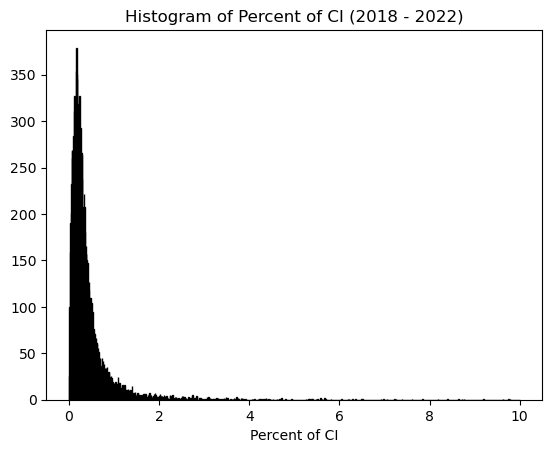

In [65]:
# Explore CI_per
breaks = [0, 0.25, 0.5, 1, 2, 5, 10, 20, 100, 200]
valid_2018_2022['Range'] = pd.cut(valid_2018_2022['CI_per'], bins=breaks, right=True, include_lowest=True)
print(valid_2018_2022['Range'].value_counts())

plt.hist(valid_2018_2022['CI_per'], bins=1000, range=(0, 10), edgecolor='black')
plt.xlabel('Percent of CI')
plt.title('Histogram of Percent of CI (2018 - 2022)')
plt.show()

# Comparison between EAGLE-I CI aggregation methods

In [68]:
print(pearsonr(valid_2018_2022['max_customer'], valid_2018_2022['daily_ci']))
print(pearsonr(valid_2018_2022['max_customer'], valid_2018_2022['daily_ci_3day_avg']))
print(pearsonr(valid_2018_2022['daily_ci'], valid_2018_2022['daily_ci_3day_avg']))

PearsonRResult(statistic=0.8473131937857701, pvalue=0.0)
PearsonRResult(statistic=0.811090679092092, pvalue=0.0)
PearsonRResult(statistic=0.9056330492206628, pvalue=0.0)


C:\Users\wanh535\AppData\Local\Temp\ipykernel_24592\2502767184.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0, 0].scatter(valid_2018_2022['max_customer'] / 1000, valid_2018_2022['daily_ci'] / 1000,
C:\Users\wanh535\AppData\Local\Temp\ipykernel_24592\2502767184.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0, 1].scatter(valid_2018_2022['max_customer'] / 1000, valid_2018_2022['daily_ci_3day_avg'] / 1000,
C:\Users\wanh535\AppData\Local\Temp\ipykernel_24592\2502767184.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[1, 0].scatter(valid_2018_2022['daily_ci'] / 1000, valid_2018_2022['daily_ci_3day_avg'] / 1000,


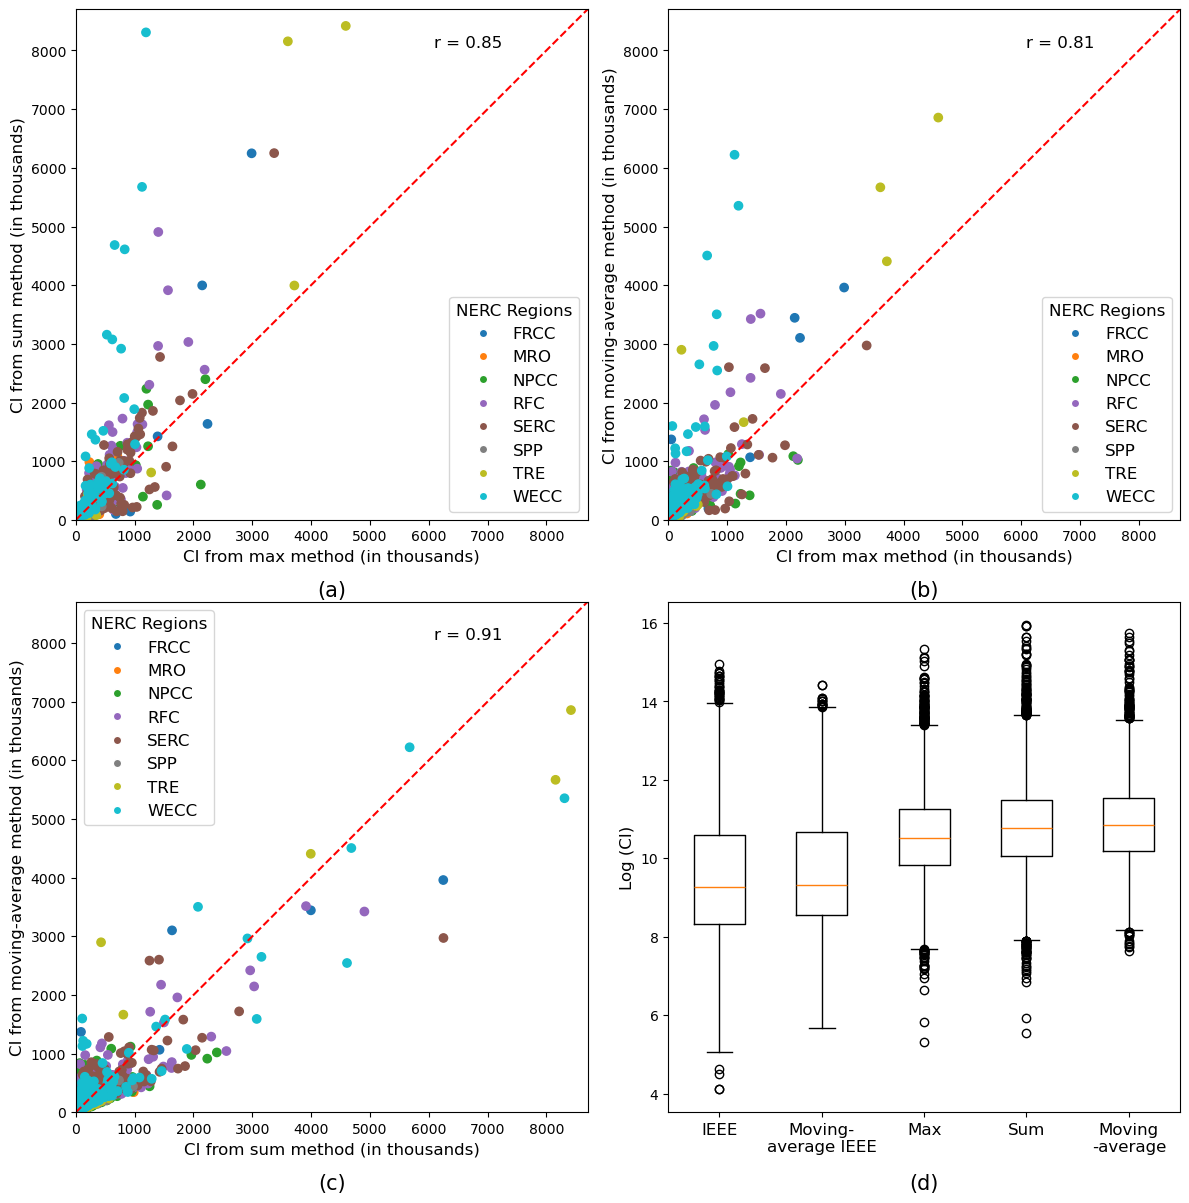

In [72]:
# Create a color map based on unique NERC categories
unique_nerc = valid_2018_2022['NERC'].unique()
cmap = plt.get_cmap('tab10', len(unique_nerc))  # Create a colormap

# Create a color dictionary to map NERC categories to colors
color_map = {nrc: cmap(i) for i, nrc in enumerate(unique_nerc)}

# Create a figure and 2x2 subplots (3 scatter plots and 1 boxplot)
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# (a) Scatterplot between 'max_customer' and 'daily_ci'
axs[0, 0].scatter(valid_2018_2022['max_customer'] / 1000, valid_2018_2022['daily_ci'] / 1000,
                   c=[color_map[nrc] for nrc in valid_2018_2022['NERC']],
                   cmap='tab10')
axs[0, 0].set_xlim(0, 8700)
axs[0, 0].set_ylim(0, 8700)
axs[0, 0].set_xlabel('CI from max method (in thousands)', fontsize=12)
axs[0, 0].set_ylabel('CI from sum method (in thousands)', fontsize=12)
axs[0, 0].plot([0, 8700], [0, 8700], color='red', linestyle='--', linewidth=1.5)  # Diagonal line
axs[0, 0].text(0.7, 0.95, 'r = 0.85', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top')

# Create custom legend handles
handles_a = [plt.Line2D([0], [0], marker='o', color='w', label=nrc,
                         markerfacecolor=color_map[nrc]) 
              for nrc in unique_nerc]
axs[0, 0].legend(handles=handles_a, title='NERC Regions', fontsize=12, title_fontsize=12)

# (b) Scatterplot between 'max_customer' and 'daily_ci_3day_avg'
axs[0, 1].scatter(valid_2018_2022['max_customer'] / 1000, valid_2018_2022['daily_ci_3day_avg'] / 1000,
                   c=[color_map[nrc] for nrc in valid_2018_2022['NERC']],
                   cmap='tab10')
axs[0, 1].set_xlim(0, 8700)
axs[0, 1].set_ylim(0, 8700)
axs[0, 1].set_xlabel('CI from max method (in thousands)', fontsize=12)
axs[0, 1].set_ylabel('CI from moving-average method (in thousands)', fontsize=12)
axs[0, 1].plot([0, 8700], [0, 8700], color='red', linestyle='--', linewidth=1.5)  # Diagonal line
axs[0, 1].text(0.7, 0.95, 'r = 0.81', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top')

# Legend handles for subplot (b)
handles_b = [plt.Line2D([0], [0], marker='o', color='w', label=nrc,
                         markerfacecolor=color_map[nrc]) 
              for nrc in unique_nerc]
axs[0, 1].legend(handles=handles_b, title='NERC Regions', fontsize=12, title_fontsize=12)

# (c) Scatterplot between 'daily_ci' and 'daily_ci_3day_avg'
axs[1, 0].scatter(valid_2018_2022['daily_ci'] / 1000, valid_2018_2022['daily_ci_3day_avg'] / 1000,
                   c=[color_map[nrc] for nrc in valid_2018_2022['NERC']],
                   cmap='tab10')
axs[1, 0].set_xlim(0, 8700)
axs[1, 0].set_ylim(0, 8700)
axs[1, 0].set_xlabel('CI from sum method (in thousands)', fontsize=12)
axs[1, 0].set_ylabel('CI from moving-average method (in thousands)', fontsize=12)
axs[1, 0].plot([0, 8700], [0, 8700], color='red', linestyle='--', linewidth=1.5)  # Diagonal line
axs[1, 0].text(0.7, 0.95, 'r = 0.91', transform=axs[1, 0].transAxes, fontsize=12, verticalalignment='top')

# Legend handles for subplot (c)
handles_c = [plt.Line2D([0], [0], marker='o', color='w', label=nrc,
                         markerfacecolor=color_map[nrc]) 
              for nrc in unique_nerc]
axs[1, 0].legend(handles=handles_c, title='NERC Regions', fontsize=12, title_fontsize=12)

# (d) Boxplot
axs[1, 1].boxplot([np.log(valid_2018_2022['CI']),
                   np.log(valid_2018_2022['CI_moving']),
                   np.log(valid_2018_2022['max_customer']),
                   np.log(valid_2018_2022['daily_ci']),
                   np.log(valid_2018_2022['daily_ci_3day_avg'])],
                  labels=["IEEE", "Moving-\naverage IEEE", "Max", "Sum", "Moving\n-average"])
axs[1, 1].set_ylabel('Log (CI)', fontsize=12)
axs[1, 1].tick_params(axis='x', labelsize=12)

# Adding (a), (b), (c), and (d) labels centered below each subplot
labels = ['(a)', '(b)', '(c)', '(d)']
for ax, label in zip(axs.flatten(), labels):
    ax.annotate(label, xy=(0.5, -0.15), xycoords='axes fraction', fontsize=15, ha='center')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
# plt.savefig("./Benchmark/Manuscript/Graphs/aggregation_method_comparison.tif", dpi=300, bbox_inches="tight")

# Show the figure
plt.show()

#  Compare the two outage datasets


In [74]:
# Pearson's correlation coefficient between the two datasets
print(pearsonr(valid_2018_2022['CI'], valid_2018_2022['max_customer']))
print(pearsonr(valid_2018_2022['CMI'], valid_2018_2022['customer_minutes']))
print(pearsonr(valid_2018_2022['CI'], valid_2018_2022['daily_ci']))
print(pearsonr(valid_2018_2022['CI'], valid_2018_2022['daily_ci_3day_avg']))
print(pearsonr(valid_2018_2022['CI_moving'], valid_2018_2022['daily_ci_3day_avg']))

# Spearman's rank correlation coefficient between the two datasets
print(spearmanr(valid_2018_2022['CI'], valid_2018_2022['max_customer']))
print(spearmanr(valid_2018_2022['CMI'], valid_2018_2022['customer_minutes']))
print(spearmanr(valid_2018_2022['CI'], valid_2018_2022['daily_ci']))
print(spearmanr(valid_2018_2022['CI'], valid_2018_2022['daily_ci_3day_avg']))
print(spearmanr(valid_2018_2022['CI_moving'], valid_2018_2022['daily_ci_3day_avg']))

PearsonRResult(statistic=0.39272601585970235, pvalue=0.0)
PearsonRResult(statistic=0.3057732733777555, pvalue=3.4099689663428626e-305)
PearsonRResult(statistic=0.3628447951122714, pvalue=0.0)
PearsonRResult(statistic=0.3342836623048531, pvalue=0.0)
PearsonRResult(statistic=0.39305121249768993, pvalue=0.0)
SignificanceResult(statistic=0.7585273949196285, pvalue=0.0)
SignificanceResult(statistic=0.786824326806196, pvalue=0.0)
SignificanceResult(statistic=0.7462233617151697, pvalue=0.0)
SignificanceResult(statistic=0.7139050005327209, pvalue=0.0)
SignificanceResult(statistic=0.7656911034435321, pvalue=0.0)


C:\Users\wanh535\AppData\Local\Temp\ipykernel_24592\1400138160.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc_a = axs[0, 0].scatter(valid_2018_2022['CI'] / 1000, valid_2018_2022['max_customer'] / 1000,
C:\Users\wanh535\AppData\Local\Temp\ipykernel_24592\1400138160.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc_b = axs[0, 1].scatter(valid_2018_2022['CI'] / 1000, valid_2018_2022['daily_ci'] / 1000,
C:\Users\wanh535\AppData\Local\Temp\ipykernel_24592\1400138160.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc_c = axs[1, 0].scatter(valid_2018_2022['CI'] / 1000, valid_2018_2022['daily_ci_3day_avg'] / 1000,
C:\Users\wanh535\AppData\Local\Temp\ipykernel_24592\1400138160.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc_d = axs[1, 1].scatter(valid_2018_2022['CI_moving'] / 1000, vali

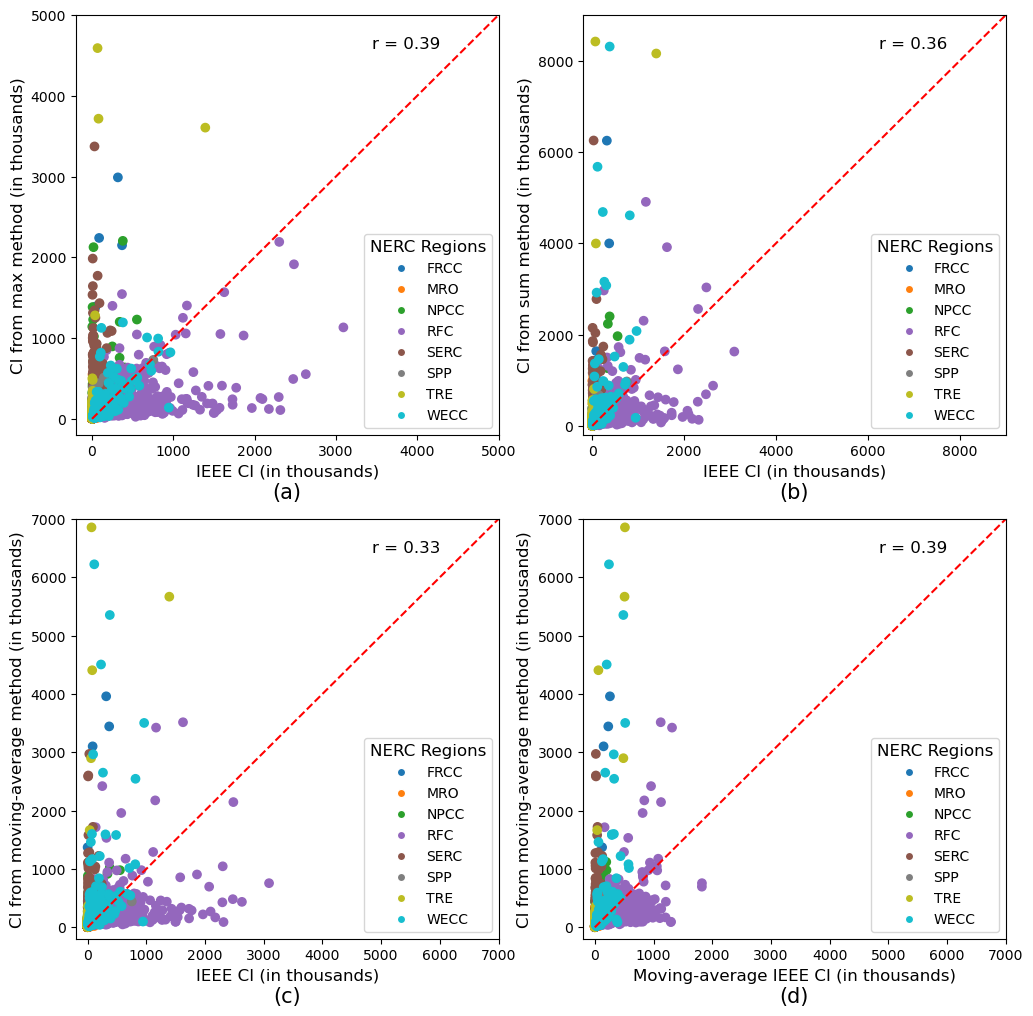

In [76]:
# Create a color dictionary for NERC regions
unique_nerc = valid_2018_2022['NERC'].unique()
cmap = plt.get_cmap('tab10', len(unique_nerc))
color_map = {nrc: cmap(i) for i, nrc in enumerate(unique_nerc)}

# Create a figure and 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# (a) IEEE CI vs. EAGLE-I daily max
sc_a = axs[0, 0].scatter(valid_2018_2022['CI'] / 1000, valid_2018_2022['max_customer'] / 1000,
                          c=[color_map[nrc] for nrc in valid_2018_2022['NERC']],
                          cmap=cmap)
axs[0, 0].set_xlim(-200, 5000)
axs[0, 0].set_ylim(-200, 5000)
axs[0, 0].set_xlabel('IEEE CI (in thousands)', fontsize=12)
axs[0, 0].set_ylabel('CI from max method (in thousands)', fontsize=12)
axs[0, 0].plot([0, 5000], [0, 5000], color='red', linestyle='--', linewidth=1.5)  # Diagonal line
axs[0, 0].text(0.7, 0.95, 'r = 0.39', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top')

# (b) IEEE CI vs. EAGLE-I Sum Positive Difference
sc_b = axs[0, 1].scatter(valid_2018_2022['CI'] / 1000, valid_2018_2022['daily_ci'] / 1000,
                          c=[color_map[nrc] for nrc in valid_2018_2022['NERC']],
                          cmap=cmap)
axs[0, 1].set_xlim(-200, 9000)
axs[0, 1].set_ylim(-200, 9000)
axs[0, 1].set_xlabel('IEEE CI (in thousands)', fontsize=12)
axs[0, 1].set_ylabel('CI from sum method (in thousands)', fontsize=12)
axs[0, 1].plot([0, 9000], [0, 9000], color='red', linestyle='--', linewidth=1.5)  # Diagonal line
axs[0, 1].text(0.7, 0.95, 'r = 0.36', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top')

# (c) IEEE CI vs. EAGLE-I Moving Average
sc_c = axs[1, 0].scatter(valid_2018_2022['CI'] / 1000, valid_2018_2022['daily_ci_3day_avg'] / 1000,
                          c=[color_map[nrc] for nrc in valid_2018_2022['NERC']],
                          cmap=cmap)
axs[1, 0].set_xlim(-200, 7000)
axs[1, 0].set_ylim(-200, 7000)
axs[1, 0].set_xlabel('IEEE CI (in thousands)', fontsize=12)
axs[1, 0].set_ylabel('CI from moving-average method (in thousands)', fontsize=12)
axs[1, 0].plot([0, 7000], [0, 7000], color='red', linestyle='--', linewidth=1.5)  # Diagonal line
axs[1, 0].text(0.7, 0.95, 'r = 0.33', transform=axs[1, 0].transAxes, fontsize=12, verticalalignment='top')

# (d) Moving-average IEEE CI vs. EAGLE-I Moving Average
sc_d = axs[1, 1].scatter(valid_2018_2022['CI_moving'] / 1000, valid_2018_2022['daily_ci_3day_avg'] / 1000,
                          c=[color_map[nrc] for nrc in valid_2018_2022['NERC']],
                          cmap=cmap)
axs[1, 1].set_xlim(-200, 7000)
axs[1, 1].set_ylim(-200, 7000)
axs[1, 1].set_xlabel('Moving-average IEEE CI (in thousands)', fontsize=12)
axs[1, 1].set_ylabel('CI from moving-average method (in thousands)', fontsize=12)
axs[1, 1].plot([0, 7000], [0, 7000], color='red', linestyle='--', linewidth=1.5)  # Diagonal line
axs[1, 1].text(0.7, 0.95, 'r = 0.39', transform=axs[1, 1].transAxes, fontsize=12, verticalalignment='top')

# Add legends for each subplot (use the same color mapping)
for ax in axs.flatten():
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=nrc, 
                          markerfacecolor=color_map[nrc]) for nrc in unique_nerc]
    ax.legend(handles=handles, title='NERC Regions', fontsize=10, title_fontsize=12)

# Adding (a), (b), (c), and (d) labels centered below each subplot
labels = ['(a)', '(b)', '(c)', '(d)']
for ax, label in zip(axs.flatten(), labels):
    ax.annotate(label, xy=(0.5, -0.15), xycoords='axes fraction', fontsize=15, ha='center')
    
# Show the figure
plt.show()

# Compare the two outage datasets by NERC region

In [79]:
# Filter the data frame by removing low CI% (select one removing threshold below)
# valid_2018_2022_v2 = valid_2018_2022[valid_2018_2022['CI_per'] > 0.25]
# valid_2018_2022_v2 = valid_2018_2022[valid_2018_2022['CI'] > 100000]
valid_2018_2022_v2 = valid_2018_2022

In [81]:
# List of NERC regions to plot
nerc_regions = ['FRCC', 'MRO', 'NPCC', 'RFC', 'SERC', 'SPP', 'TRE', 'WECC']
pearson_all = round(valid_2018_2022_v2['max_customer'].corr(valid_2018_2022_v2['CI']), 2)
spearman_all = round(valid_2018_2022_v2['max_customer'].corr(valid_2018_2022_v2['CI'], method = 'spearman'), 2)
print(f"ALL: Pearson = {pearson_all}; Spearman = {spearman_all}")

for region in nerc_regions: 
    data = valid_2018_2022_v2.loc[valid_2018_2022_v2['NERC'] == region]
    size = data.shape
    pearson = round(data['max_customer'].corr(data['CI']), 2)
    spearman = round(data['max_customer'].corr(data['CI'], method = 'spearman'), 2)
    print(f"{region}: Size = {size}; Pearson = {pearson}; Spearman = {spearman}")




ALL: Pearson = 0.39; Spearman = 0.76
FRCC: Size = (1776, 13); Pearson = 0.78; Spearman = 0.64
MRO: Size = (1776, 13); Pearson = 0.48; Spearman = 0.66
NPCC: Size = (1776, 13); Pearson = 0.63; Spearman = 0.74
RFC: Size = (1776, 13); Pearson = 0.54; Spearman = 0.65
SERC: Size = (1776, 13); Pearson = 0.36; Spearman = 0.63
SPP: Size = (1776, 13); Pearson = 0.72; Spearman = 0.81
TRE: Size = (1776, 13); Pearson = 0.57; Spearman = 0.55
WECC: Size = (1776, 13); Pearson = 0.72; Spearman = 0.65


In [83]:
# List of NERC regions to plot
nerc_regions = ['FRCC', 'MRO', 'NPCC', 'RFC', 'SERC', 'SPP', 'TRE', 'WECC']
pearson_all = round(valid_2018_2022_v2['daily_ci'].corr(valid_2018_2022_v2['CI']), 2)
spearman_all = round(valid_2018_2022_v2['daily_ci'].corr(valid_2018_2022_v2['CI'], method = 'spearman'), 2)
print(f"ALL: Pearson = {pearson_all}; Spearman = {spearman_all}")

for region in nerc_regions: 
    data = valid_2018_2022_v2.loc[valid_2018_2022_v2['NERC'] == region]
    pearson = round(data['daily_ci'].corr(data['CI']), 2)
    spearman = round(data['daily_ci'].corr(data['CI'], method = 'spearman'), 2)
    print(f"{region}: Pearson = {pearson}; Spearman = {spearman}")

ALL: Pearson = 0.36; Spearman = 0.75
FRCC: Pearson = 0.85; Spearman = 0.65
MRO: Pearson = 0.42; Spearman = 0.67
NPCC: Pearson = 0.84; Spearman = 0.75
RFC: Pearson = 0.5; Spearman = 0.67
SERC: Pearson = 0.38; Spearman = 0.66
SPP: Pearson = 0.82; Spearman = 0.82
TRE: Pearson = 0.7; Spearman = 0.54
WECC: Pearson = 0.45; Spearman = 0.66


In [85]:
# List of NERC regions to plot
nerc_regions = ['FRCC', 'MRO', 'NPCC', 'RFC', 'SERC', 'SPP', 'TRE', 'WECC']
pearson_all = round(valid_2018_2022_v2['daily_ci_3day_avg'].corr(valid_2018_2022_v2['CI']), 2)
spearman_all = round(valid_2018_2022_v2['daily_ci_3day_avg'].corr(valid_2018_2022_v2['CI'], method = 'spearman'), 2)
print(f"ALL: Pearson = {pearson_all}; Spearman = {spearman_all}")

for region in nerc_regions: 
    data = valid_2018_2022_v2.loc[valid_2018_2022_v2['NERC'] == region]
    pearson = round(data['daily_ci_3day_avg'].corr(data['CI']), 2)
    spearman = round(data['daily_ci_3day_avg'].corr(data['CI'], method = 'spearman'), 2)
    print(f"{region}: Pearson = {pearson}; Spearman = {spearman}")

ALL: Pearson = 0.33; Spearman = 0.71
FRCC: Pearson = 0.77; Spearman = 0.58
MRO: Pearson = 0.38; Spearman = 0.59
NPCC: Pearson = 0.57; Spearman = 0.6
RFC: Pearson = 0.42; Spearman = 0.59
SERC: Pearson = 0.32; Spearman = 0.59
SPP: Pearson = 0.57; Spearman = 0.67
TRE: Pearson = 0.6; Spearman = 0.46
WECC: Pearson = 0.41; Spearman = 0.57


In [87]:
# List of NERC regions to plot
nerc_regions = ['FRCC', 'MRO', 'NPCC', 'RFC', 'SERC', 'SPP', 'TRE', 'WECC']
pearson_all = round(valid_2018_2022_v2['daily_ci_3day_avg'].corr(valid_2018_2022_v2['CI_moving']), 2)
spearman_all = round(valid_2018_2022_v2['daily_ci_3day_avg'].corr(valid_2018_2022_v2['CI_moving'], method = 'spearman'), 2)
print(f"ALL: Pearson = {pearson_all}; Spearman = {spearman_all}")

for region in nerc_regions: 
    data = valid_2018_2022_v2.loc[valid_2018_2022_v2['NERC'] == region]
    pearson = round(data['daily_ci_3day_avg'].corr(data['CI_moving']), 2)
    spearman = round(data['daily_ci_3day_avg'].corr(data['CI_moving'], method = 'spearman'), 2)
    print(f"{region}: Pearson = {pearson}; Spearman = {spearman}")

ALL: Pearson = 0.39; Spearman = 0.77
FRCC: Pearson = 0.91; Spearman = 0.77
MRO: Pearson = 0.49; Spearman = 0.76
NPCC: Pearson = 0.85; Spearman = 0.83
RFC: Pearson = 0.54; Spearman = 0.67
SERC: Pearson = 0.41; Spearman = 0.71
SPP: Pearson = 0.83; Spearman = 0.89
TRE: Pearson = 0.87; Spearman = 0.62
WECC: Pearson = 0.52; Spearman = 0.7


# IEEE CI v.s. EAGLE-I CI from max method

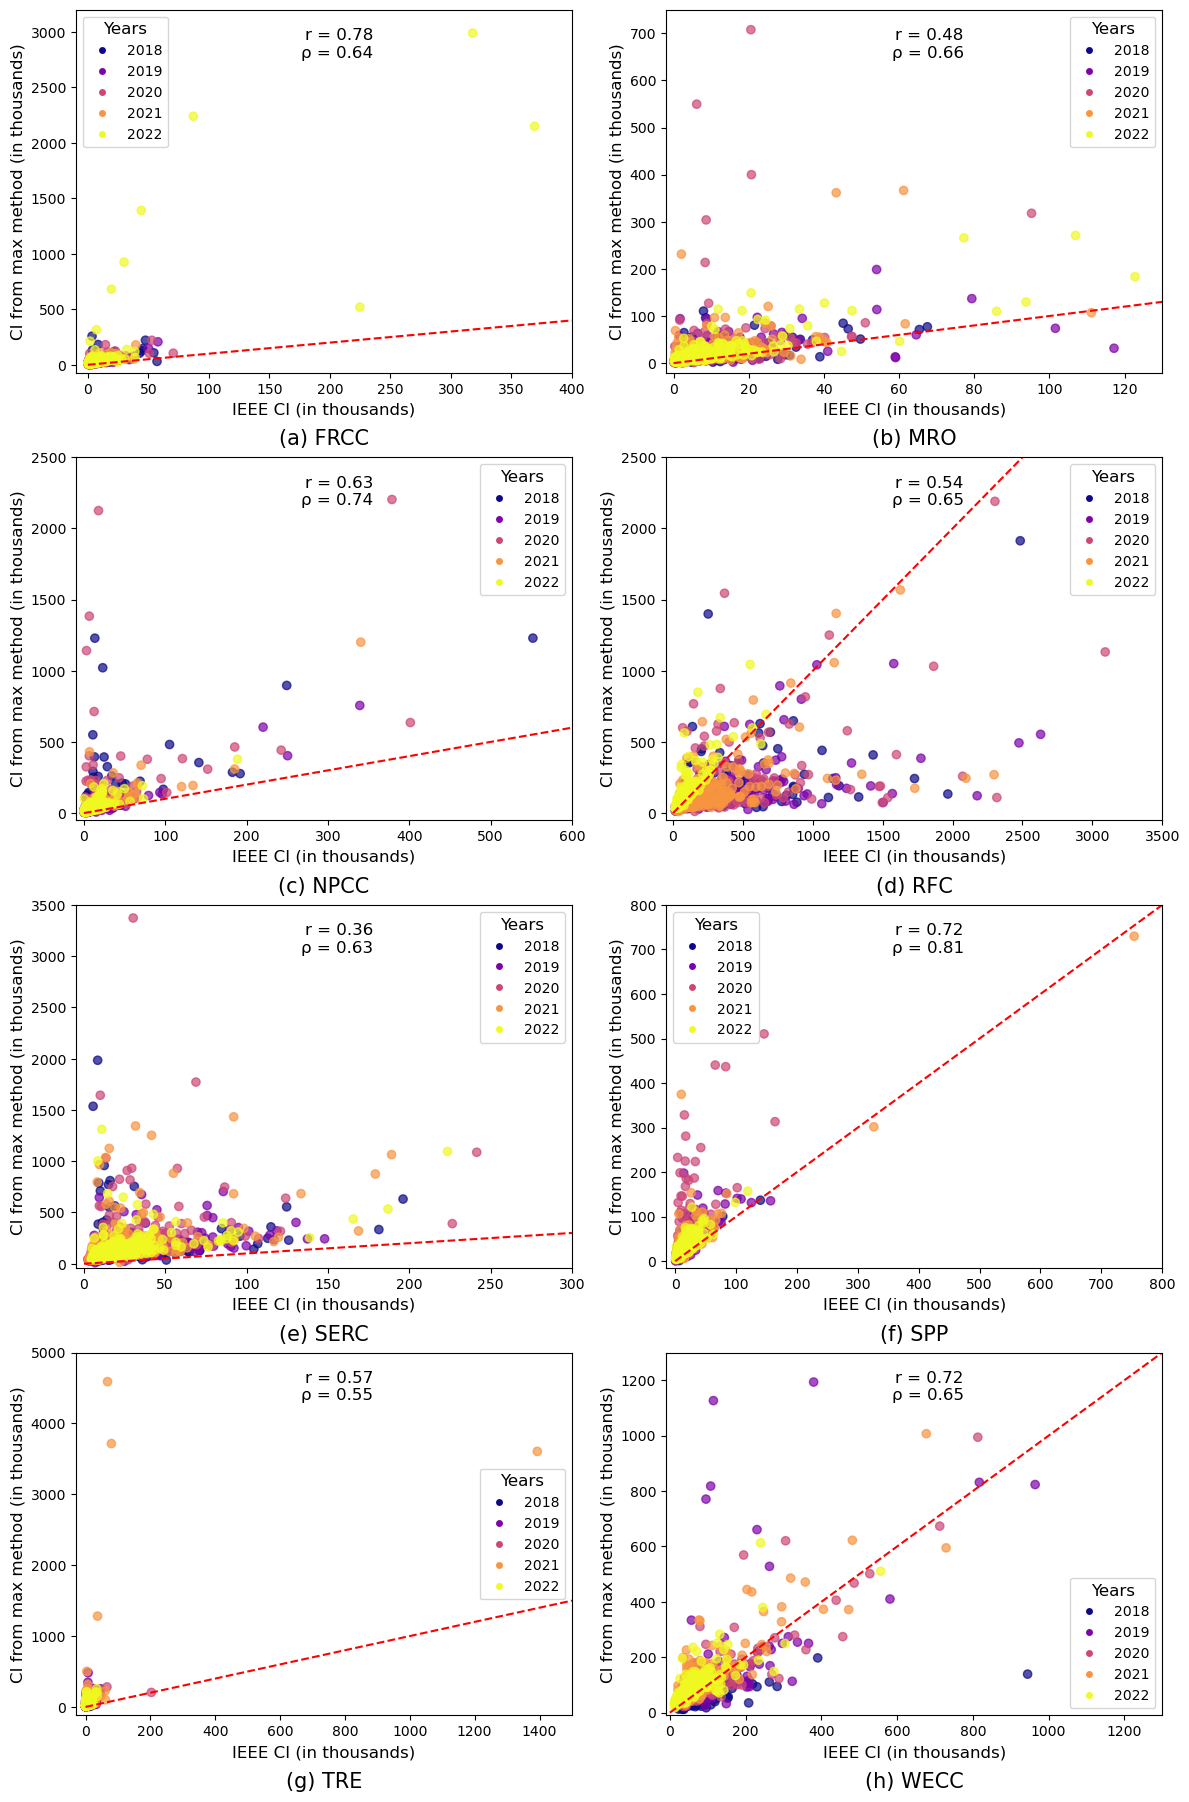

In [90]:
# List of NERC regions to plot
nerc_regions = ['FRCC', 'MRO', 'NPCC', 'RFC', 'SERC', 'SPP', 'TRE', 'WECC']

# Define manual xlim and ylim for each NERC region
limits = {
    'FRCC': {'xlim': [-10, 400], 'ylim': [-70, 3200]},
    'MRO': {'xlim': [-2, 130], 'ylim': [-20, 750]},
    'NPCC': {'xlim': [-10, 600], 'ylim': [-50, 2500]},
    'RFC': {'xlim': [-50, 3500], 'ylim': [-50, 2500]},
    'SERC': {'xlim': [-5, 300], 'ylim': [-40, 3500]},
    'SPP': {'xlim': [-15, 800], 'ylim': [-15, 800]},
    'TRE': {'xlim': [-30, 1500], 'ylim': [-120, 5000]},
    'WECC': {'xlim': [-10, 1300], 'ylim': [-10, 1300]}
}

# Create a figure with 4 rows and 2 columns of subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 18))
axs = axs.flatten()  # Flatten the 2D array of axes to easily iterate through

# Loop through each NERC region
for i, nerc in enumerate(nerc_regions):
    target = valid_2018_2022[valid_2018_2022['NERC'] == nerc]

    # Calculate Pearson's and Spearman's correlation coefficients
    pearson_corr, _ = pearsonr(target['CI'], target['max_customer'])
    spearman_corr, _ = spearmanr(target['CI'], target['max_customer'])

    # Scatter plot for the specific NERC region
    scatter = axs[i].scatter(target['CI'] / 1000, target['max_customer'] / 1000,
                             c=target['Year'], cmap='plasma', alpha=0.7)

    # Set manual x and y limits based on the defined limits
    axs[i].set_xlim(limits[nerc]['xlim'])
    axs[i].set_ylim(limits[nerc]['ylim'])

    axs[i].set_xlabel('IEEE CI (in thousands)', fontsize=12)
    axs[i].set_ylabel('CI from max method (in thousands)', fontsize=12)

    # Add a diagonal reference line
    axs[i].plot([0, limits[nerc]['xlim'][1]], [0, limits[nerc]['xlim'][1]], color='red', linestyle='--', linewidth=1.5)  # Diagonal line

    # Adding a legend for years
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=year,
                           markerfacecolor=scatter.cmap(scatter.norm(year)))
               for year in sorted(target['Year'].unique())]
    axs[i].legend(handles=handles, title='Years', fontsize=10, title_fontsize=12)

    # Adjust the annotation position to prevent overlap
    axs[i].annotate(f'({chr(97 + i)}) {nerc}', 
                    xy=(0.5, -0.2), 
                    xycoords='axes fraction', 
                    fontsize=15, 
                    ha='center')
    # Display correlation coefficients on the top-right corner of the subplot
    axs[i].text(0.6, 0.95,
                f'r = {pearson_corr:.2f}\nρ = {spearman_corr:.2f}',
                transform=axs[i].transAxes,
                fontsize=12,
                ha='right',
                va='top')
    

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

# IEEE CI v.s. EAGLE-I CI from sum method

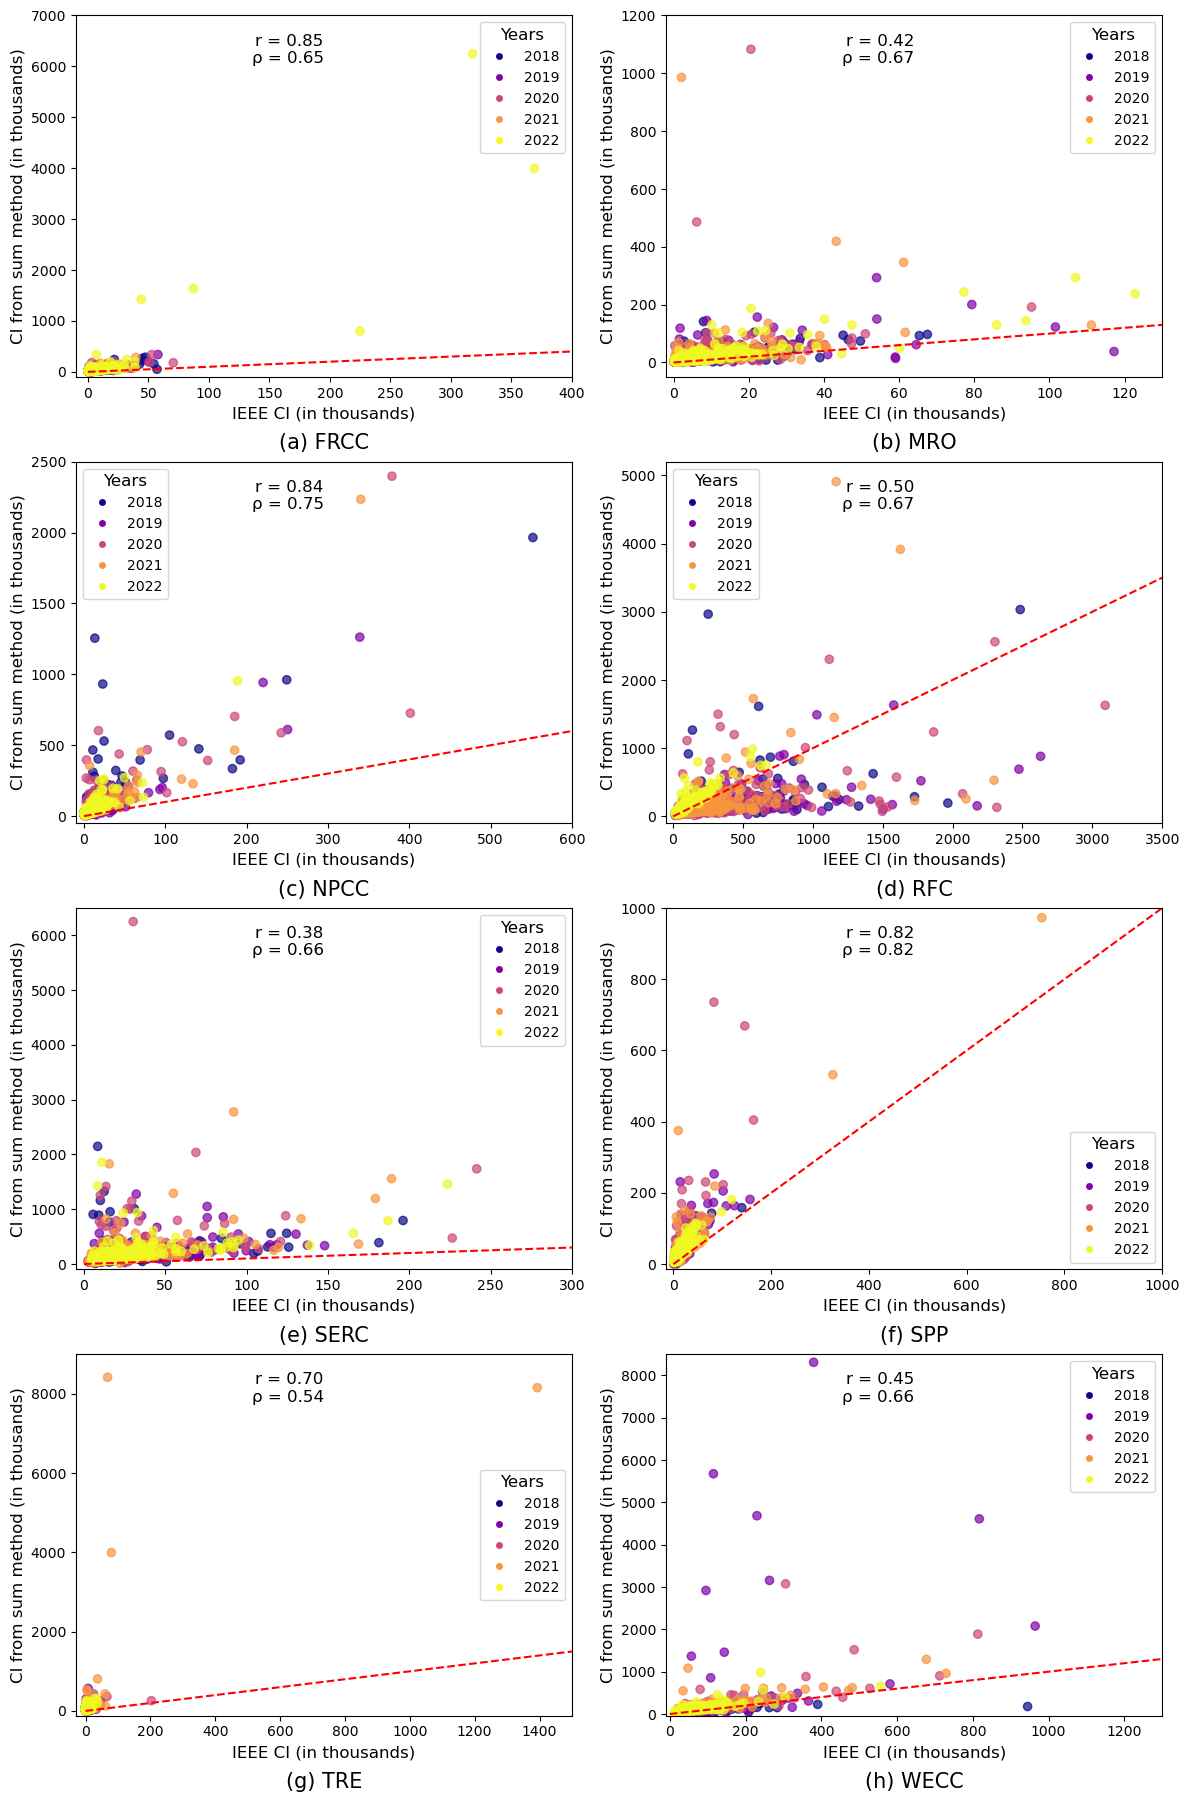

In [92]:
# List of NERC regions to plot
nerc_regions = ['FRCC', 'MRO', 'NPCC', 'RFC', 'SERC', 'SPP', 'TRE', 'WECC']

# Define manual xlim and ylim for each NERC region
limits = {
    'FRCC': {'xlim': [-10, 400], 'ylim': [-100, 7000]},
    'MRO': {'xlim': [-2, 130], 'ylim': [-50, 1200]},
    'NPCC': {'xlim': [-10, 600], 'ylim': [-50, 2500]},
    'RFC': {'xlim': [-50, 3500], 'ylim': [-100, 5200]},
    'SERC': {'xlim': [-5, 300], 'ylim': [-100, 6500]},
    'SPP': {'xlim': [-15, 1000], 'ylim': [-15, 1000]},
    'TRE': {'xlim': [-30, 1500], 'ylim': [-120, 9000]},
    'WECC': {'xlim': [-10, 1300], 'ylim': [-40, 8500]}
}

# Create a figure with 4 rows and 2 columns of subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 18))
axs = axs.flatten()  # Flatten the 2D array of axes to easily iterate through

# Loop through each NERC region
for i, nerc in enumerate(nerc_regions):
    target = valid_2018_2022[valid_2018_2022['NERC'] == nerc]

    # Calculate Pearson's and Spearman's correlation coefficients
    pearson_corr, _ = pearsonr(target['CI'], target['daily_ci'])
    spearman_corr, _ = spearmanr(target['CI'], target['daily_ci'])

    # Scatter plot for the specific NERC region
    scatter = axs[i].scatter(target['CI'] / 1000, target['daily_ci'] / 1000,
                             c=target['Year'], cmap='plasma', alpha=0.7)

    # Set manual x and y limits based on the defined limits
    axs[i].set_xlim(limits[nerc]['xlim'])
    axs[i].set_ylim(limits[nerc]['ylim'])

    axs[i].set_xlabel('IEEE CI (in thousands)', fontsize=12)
    axs[i].set_ylabel('CI from sum method (in thousands)', fontsize=12)

    # Add a diagonal reference line
    axs[i].plot([0, limits[nerc]['xlim'][1]], [0, limits[nerc]['xlim'][1]], color='red', linestyle='--', linewidth=1.5)  # Diagonal line

    # Adding a legend for years
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=year,
                           markerfacecolor=scatter.cmap(scatter.norm(year)))
               for year in sorted(target['Year'].unique())]
    axs[i].legend(handles=handles, title='Years', fontsize=10, title_fontsize=12)

    # Adjust the annotation position to prevent overlap
    axs[i].annotate(f'({chr(97 + i)}) {nerc}', 
                    xy=(0.5, -0.2), 
                    xycoords='axes fraction', 
                    fontsize=15, 
                    ha='center')
        
    
    # Display correlation coefficients on the top-right corner of the subplot
    axs[i].text(0.5, 0.95,
                f'r = {pearson_corr:.2f}\nρ = {spearman_corr:.2f}',
                transform=axs[i].transAxes,
                fontsize=12,
                ha='right',
                va='top')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

# IEEE CI v.s. EAGLE-I CI from moving-average method

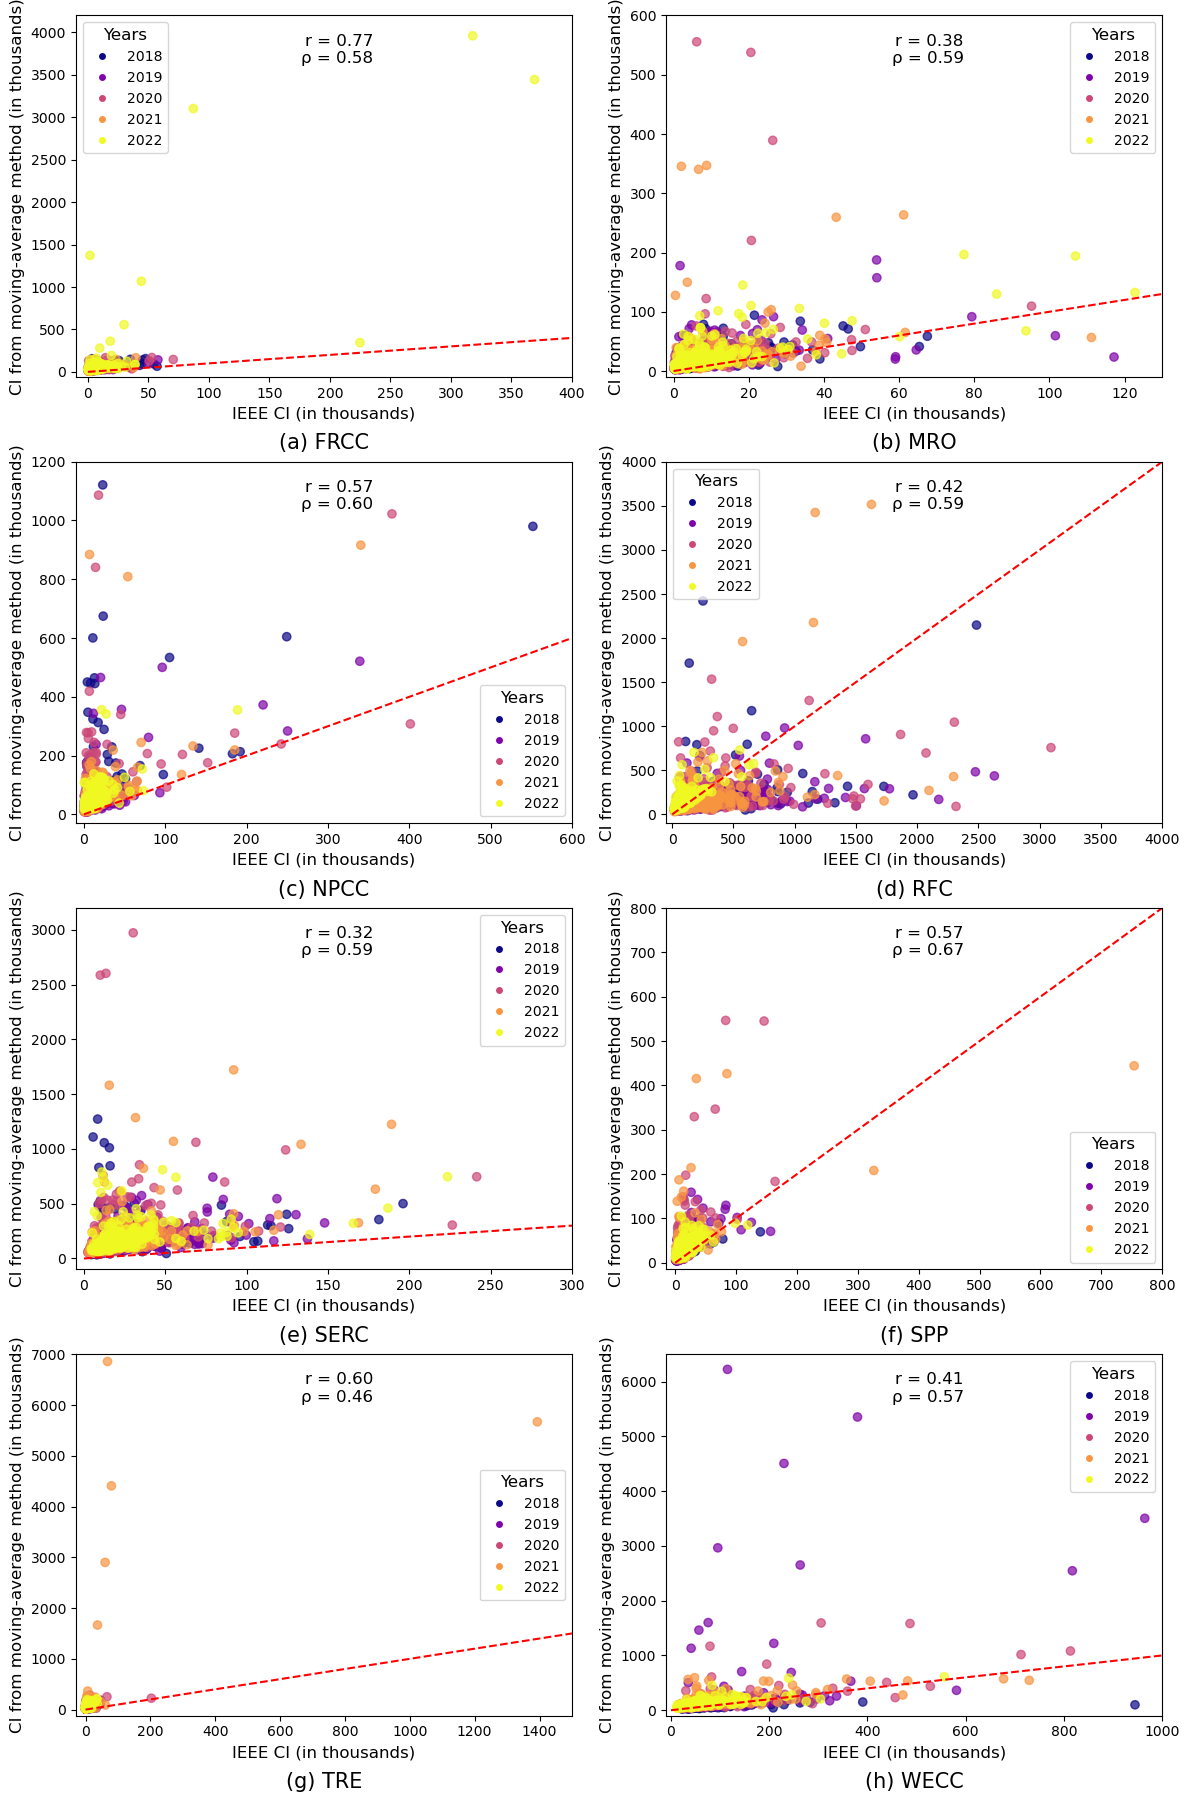

In [31]:
# List of NERC regions to plot
nerc_regions = ['FRCC', 'MRO', 'NPCC', 'RFC', 'SERC', 'SPP', 'TRE', 'WECC']

# Define manual xlim and ylim for each NERC region
limits = {
    'FRCC': {'xlim': [-10, 400], 'ylim': [-60, 4200]},
    'MRO': {'xlim': [-2, 130], 'ylim': [-10, 600]},
    'NPCC': {'xlim': [-10, 600], 'ylim': [-30, 1200]},
    'RFC': {'xlim': [-50, 4000], 'ylim': [-100, 4000]},
    'SERC': {'xlim': [-5, 300], 'ylim': [-100, 3200]},
    'SPP': {'xlim': [-15, 800], 'ylim': [-15, 800]},
    'TRE': {'xlim': [-30, 1500], 'ylim': [-120, 7000]},
    'WECC': {'xlim': [-10, 1000], 'ylim': [-100, 6500]}
}

# Create a figure with 4 rows and 2 columns of subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 18))
axs = axs.flatten()  # Flatten the 2D array of axes to easily iterate through

# Loop through each NERC region
for i, nerc in enumerate(nerc_regions):
    target = valid_2018_2022[valid_2018_2022['NERC'] == nerc]

    # Calculate Pearson's and Spearman's correlation coefficients
    pearson_corr, _ = pearsonr(target['CI'], target['daily_ci_3day_avg'])
    spearman_corr, _ = spearmanr(target['CI'], target['daily_ci_3day_avg'])

    # Scatter plot for the specific NERC region
    scatter = axs[i].scatter(target['CI'] / 1000, target['daily_ci_3day_avg'] / 1000,
                             c=target['Year'], cmap='plasma', alpha=0.7)

    # Set manual x and y limits based on the defined limits
    axs[i].set_xlim(limits[nerc]['xlim'])
    axs[i].set_ylim(limits[nerc]['ylim'])

    axs[i].set_xlabel('IEEE CI (in thousands)', fontsize=12)
    axs[i].set_ylabel('CI from moving-average method (in thousands)', fontsize=12)

    # Add a diagonal reference line
    axs[i].plot([0, limits[nerc]['xlim'][1]], [0, limits[nerc]['xlim'][1]], color='red', linestyle='--', linewidth=1.5)  # Diagonal line

    # Adding a legend for years
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=year,
                           markerfacecolor=scatter.cmap(scatter.norm(year)))
               for year in sorted(target['Year'].unique())]
    axs[i].legend(handles=handles, title='Years', fontsize=10, title_fontsize=12)

    # Adjust the annotation position to prevent overlap
    axs[i].annotate(f'({chr(97 + i)}) {nerc}', 
                    xy=(0.5, -0.2), 
                    xycoords='axes fraction', 
                    fontsize=15, 
                    ha='center')

    # Display correlation coefficients on the top-right corner of the subplot
    axs[i].text(0.6, 0.95,
                f'r = {pearson_corr:.2f}\nρ = {spearman_corr:.2f}',
                transform=axs[i].transAxes,
                fontsize=12,
                ha='right',
                va='top')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

# 

# Moving-average IEEE CI v.s. EAGLE-I CI from moving-average method

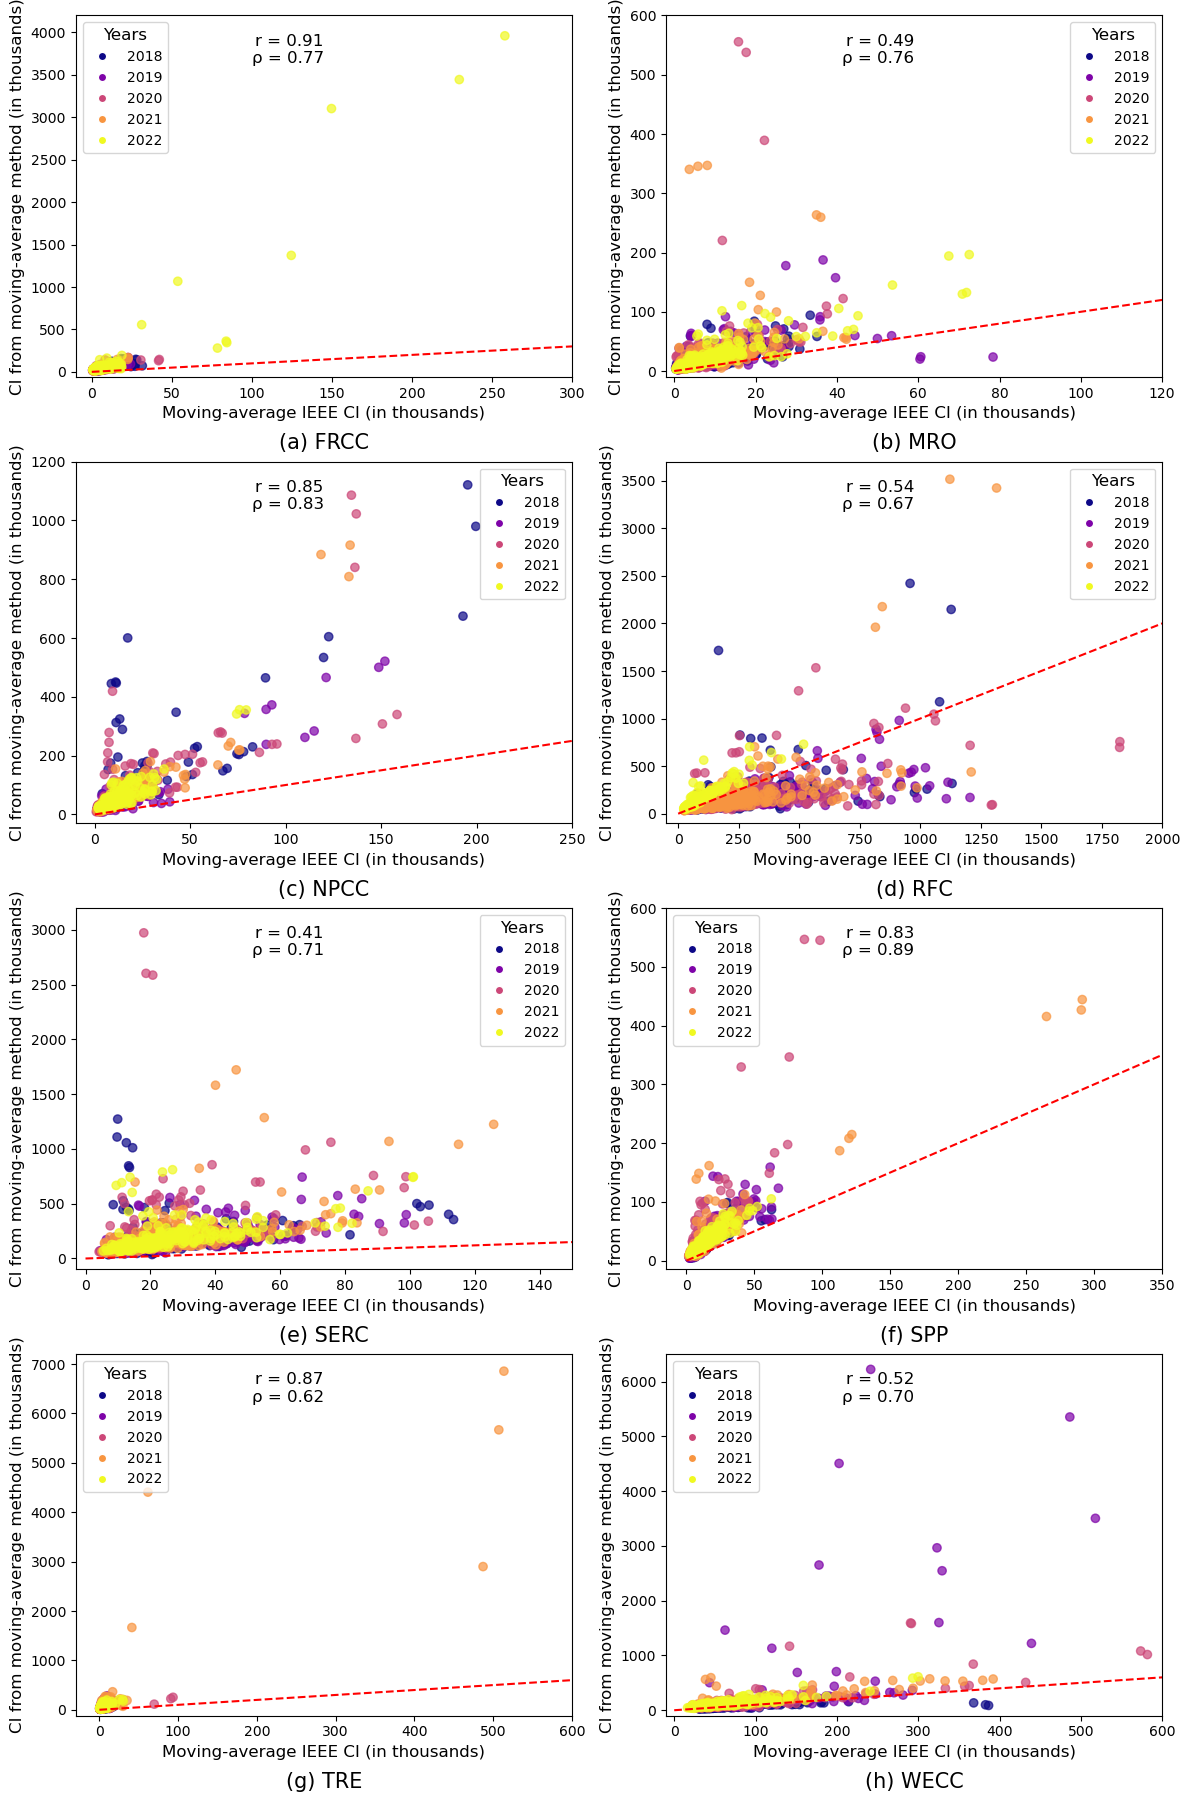

In [94]:
# List of NERC regions to plot
nerc_regions = ['FRCC', 'MRO', 'NPCC', 'RFC', 'SERC', 'SPP', 'TRE', 'WECC']

# Define manual xlim and ylim for each NERC region
limits = {
    'FRCC': {'xlim': [-10, 300], 'ylim': [-60, 4200]},
    'MRO': {'xlim': [-2, 120], 'ylim': [-10, 600]},
    'NPCC': {'xlim': [-10, 250], 'ylim': [-30, 1200]},
    'RFC': {'xlim': [-50, 2000], 'ylim': [-100, 3700]},
    'SERC': {'xlim': [-3, 150], 'ylim': [-100, 3200]},
    'SPP': {'xlim': [-15, 350], 'ylim': [-15, 600]},
    'TRE': {'xlim': [-30, 600], 'ylim': [-120, 7200]},
    'WECC': {'xlim': [-10, 600], 'ylim': [-100, 6500]}
}

# Create a figure with 4 rows and 2 columns of subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 18))
axs = axs.flatten()  # Flatten the 2D array of axes to easily iterate through

# Loop through each NERC region
for i, nerc in enumerate(nerc_regions):
    target = valid_2018_2022[valid_2018_2022['NERC'] == nerc]

    # Calculate Pearson's and Spearman's correlation coefficients
    pearson_corr, _ = pearsonr(target['CI_moving'], target['daily_ci_3day_avg'])
    spearman_corr, _ = spearmanr(target['CI_moving'], target['daily_ci_3day_avg'])

    # Scatter plot for the specific NERC region
    scatter = axs[i].scatter(target['CI_moving'] / 1000, target['daily_ci_3day_avg'] / 1000,
                             c=target['Year'], cmap='plasma', alpha=0.7)

    # Set manual x and y limits based on the defined limits
    axs[i].set_xlim(limits[nerc]['xlim'])
    axs[i].set_ylim(limits[nerc]['ylim'])

    axs[i].set_xlabel('Moving-average IEEE CI (in thousands)', fontsize=12)
    axs[i].set_ylabel('CI from moving-average method (in thousands)', fontsize=12)

    # Add a diagonal reference line
    axs[i].plot([0, limits[nerc]['xlim'][1]], [0, limits[nerc]['xlim'][1]], color='red', linestyle='--', linewidth=1.5)  # Diagonal line

    # Adding a legend for years
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=year,
                           markerfacecolor=scatter.cmap(scatter.norm(year)))
               for year in sorted(target['Year'].unique())]
    axs[i].legend(handles=handles, title='Years', fontsize=10, title_fontsize=12)

    # Adjust the annotation position to prevent overlap
    axs[i].annotate(f'({chr(97 + i)}) {nerc}', 
                    xy=(0.5, -0.2), 
                    xycoords='axes fraction', 
                    fontsize=15, 
                    ha='center')

    # Display correlation coefficients on the top-right corner of the subplot
    axs[i].text(0.5, 0.95,
                f'r = {pearson_corr:.2f}\nρ = {spearman_corr:.2f}',
                transform=axs[i].transAxes,
                fontsize=12,
                ha='right',
                va='top')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()